# Assignment 3 

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>


## Importing packages

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import gymnasium as gym
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import os


os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
rnd = np.random.default_rng(112233)

# turn of warnings
import warnings
warnings.filterwarnings('ignore')

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Building Cart Pole Q-learning

In [50]:
env = gym.make('CartPole-v1')

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Building Q-learning class

I will be providing the code for the qlearning from the last assignment along the code for this assignment in the same class. However some functions will only be used by the data generator.

In [51]:
class qlearning:
    def __init__(self, env, alpha=.85, gamma=.95, epsilon=.1, bins=10,penalty=250,lr_model=None):
        self.a = alpha
        self.g = gamma
        self.e = epsilon
        self.n_bins = bins
        self.env = env
        self.penalty = penalty
        self.greedy=False
        self.lr_model = lr_model
        
        # changing bounds into more compact values to speed up training (fewer bins needed for this accuracy):
        self.env_space = [[3, -3],
                          [6, -6],
                          [0.300, -0.300],
                          [5, -5]]

        self.q = self.gen_table()
        
        return

    def gen_table(self):
        action_dim = self.env.action_space.n

        table = np.random.uniform(low=-0.001, high=0.001, size=(self.n_bins, self.n_bins, self.n_bins, self.n_bins, action_dim))

        self.q = table
        return self.q

    def update(self, reward, state, action, next_state):
        a, b, c, d, e = self.get_s(state, action)
        a_, b_, c_, d_ = self.get_s(next_state)

        self.q[a][b][c][d][e] = self.q[a][b][c][d][e] + self.a * (
                reward + self.g * np.max(self.q[a_][b_][c_][d_]) - self.q[a][b][c][d][e])

        return None
    
    def get_q_value(self,state,action):
        a, b, c, d, e = self.get_s(state, action)
        return self.q[a][b][c][d][e]
    
    def offline_update(self,state, action, error):
        a, b, c, d, e = self.get_s(state, action)
        e = int(e)
        self.q[a][b][c][d][e] = self.q[a][b][c][d][e] - error

        return None

    def choose(self, state,imitation=False,get_max=False):

        if imitation:
            
            return int(self.lr_model.predict(np.array(state).reshape((1,-1)))[0])
        
        if (rnd.random() < self.e) and (not self.greedy):
            # random sampling
            chosen = rnd.choice(list(range(self.env.action_space.n)))
        else:
            # greedy choice
            table = self.q
            for miniState in self.get_s(state):
                table = table[miniState]

            chosen = np.argmax(table)
            
        if get_max:
            return table[chosen]
        return chosen
    
    def get(self,state,table=None,action=None):
        if table is None:
            table = self.q

        for miniState in self.get_s(state):
                table = table[miniState]

        if action is None:
            chosen = np.argmax(table)
            return table[chosen], chosen
        else:
            return table[int(action)]

    def get_s(self, state, action=None):
        indexes = []
        for i, feature in enumerate(state):
            max_value = self.env_space[i][0]
            min_value = self.env_space[i][1]

            if (feature > max_value) or (feature < min_value):
                raise ValueError(
                    f"Feature out of bounds for feature{str(i)} on bins : {str(feature)}  |min : {str(min_value)} - "
                    f"max :{str(max_value)}|")
            window_size = (max_value - min_value) / self.n_bins
            bin_loc = (feature - min_value) // window_size
            indexes.append(int(bin_loc))

        if action is None:
            return indexes
        else:
            return indexes + [action]
        

    def episode(self,imitation=False):
        state = self.env.reset()[0]
        ended = False
        ep_reward = 0
        ep_history = []
        

        while not ended:

            action = self.choose(state,imitation=imitation)

            # take A from S and get S'
            new_state, reward, ended, time_limit, prob = env.step(action)

            if ended:
                reward -= self.penalty
            self.update(reward, state, action, new_state)
            
            ep_history.append(np.array([x for x in state] + [action] + [y for y in new_state] + [reward] + [self.get_q_value(state,action)]))

            # S <- S'
            state = new_state
            ep_reward += reward
            if time_limit:
                break

        return ep_reward,np.array(ep_history)
    
    def offline_train(self, data, k=10):
        
        weights = np.zeros((self.n_bins, self.n_bins, self.n_bins, self.n_bins, self.env.action_space.n))
        
        for epoch in range(k):
            total_error = 0
            for batch in np.array_split(data, 10):
                
                grad = np.zeros_like(weights)

                for index, row in batch.iterrows():
                    state = list(row[['s1','s2','s3','s4']])
                    next_state = list(row[['ns1','ns2','ns3','ns4']])
                    action = row['action']
                    r = row['reward']
                    q_target = row['q_value'] # the q_value obtained in the expert system (used only for debugging)

                    max_Q_next, _ = self.get(next_state)  # get maximum expected value for the next state

                    target = r + self.g * max_Q_next

                    Q_predicted = self.get(state, action=action)
                    # get the current value for the state with action
                    # we want to approximate the next to the current one and then

                    # calculating the error for  this data_point
                    error = Q_predicted - target
                    
                    # updating the Q-function with gradient decent
                    self.offline_update(state,action,error)

        return 
    
    # train
    def train(self, episode_n=1000, verbose=False,use_model=False):
        run_results = []
        for i, mode in enumerate(range(episode_n)):
            if verbose and (len(run_results) > 1):
                print(f"\n{i + 1}th Segment: {np.mean(run_results)} avg reward", end='')
            reward, history = self.episode()
            run_results.append(reward)

        return run_results
    
    def gen_data(self,episodes=500,imitation=False,reward_=False):
        self.greedy = True
        
        history_results = []
        reward_results = []
        for i in range(episodes):
            reward, history =  self.episode(imitation=imitation)
            for ep in history:
                history_results.append(np.append(ep,i))
            reward_results.append(reward)
        
        self.greedy = False
        if reward_:
            return reward_results, history_results
        else:
            return history_results
    


<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Training the expert system

For this process, the expert system was the normal Q-learning instead of the Actor-Critic since in the last assignment my classical Q-learning achieved better results. Also, the training here will be of 10000 episodes to make sure the expert system   gives good data for this assignments results.

In [52]:
# picking best configurations from last assignment
n_bins = 10

epsilon = .15
learning_rate = 1 / 4

#setting one default rng for numpy 
rnd = np.random.default_rng(112233)


In [53]:
# expert model

if not os.path.exists('Data'):
    os.mkdir('Data')

if not os.path.exists(f'Data/Data{str(500)}.csv'):
    model = qlearning(env, alpha=learning_rate, epsilon=epsilon, bins=n_bins)
    _ = model.train(episode_n=10000)

# random model
if not os.path.exists(f'Data_random/Data{str(500)}.csv'):
    random_model = qlearning(env, alpha=learning_rate, epsilon=1, bins=n_bins)
    _ = random_model.train(episode_n=10000)
    

In [54]:
# Generating Data for the normal greedy model

for size in [100,250,500]:
    if not os.path.exists(f'Data/Data{str(size)}.csv'):
        data = np.array(model.gen_data(size))
        df = pd.DataFrame(data, columns=['s1','s2','s3','s4', 'action', 'ns1','ns2','ns3','ns4', 'reward','q_value','episode'])
        df.to_csv(f'Data/Data{str(size)}.csv', index=False, sep=';', encoding='utf-8') # saving data
    else:
        df = pd.read_csv(f'Data/Data{str(size)}.csv', sep=';', encoding='utf-8')
    
    

In [55]:
# Generating Data for the random  model
if not os.path.exists('Data_random'):
    os.mkdir('Data_random')
    
for size in [100,250,500]:
    if not os.path.exists(f'Data_random/Data{size}.csv'):
        data = np.array(random_model.gen_data(size))
        df_random = pd.DataFrame(data, columns=['s1','s2','s3','s4', 'action', 'ns1','ns2','ns3','ns4', 'reward','q_value','episode'])
        df_random.to_csv(f'Data_random/Data{size}.csv', index=False, sep=';', encoding='utf-8') # saving data
    else:
        df_random = pd.read_csv(f'Data_random/Data{size}.csv', sep=';', encoding='utf-8')


In [56]:
# data snippet
df.head(5)

,s1,s2,s3,s4,action,ns1,ns2,ns3,ns4,reward,q_value,episode
0,-0.013980,0.039977,-0.019512,0.040398,1.0,-0.013181,0.235373,-0.018704,-0.258377,1.0,18.517505,0.0
1,-0.013181,0.235373,-0.018704,-0.258377,0.0,-0.008473,0.040523,-0.023872,0.028348,1.0,18.339857,0.0
2,-0.008473,0.040523,-0.023872,0.028348,1.0,-0.007663,0.235979,-0.023305,-0.271770,1.0,18.493845,0.0
3,-0.007663,0.235979,-0.023305,-0.271770,0.0,-0.002943,0.041198,-0.028740,0.013472,1.0,18.397181,0.0
4,-0.002943,0.041198,-0.028740,0.013472,1.0,-0.002119,0.236720,-0.028471,-0.288138,1.0,18.489714,0.0


<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>


## Preparing data split

Text(0, 0.5, 'Runs')

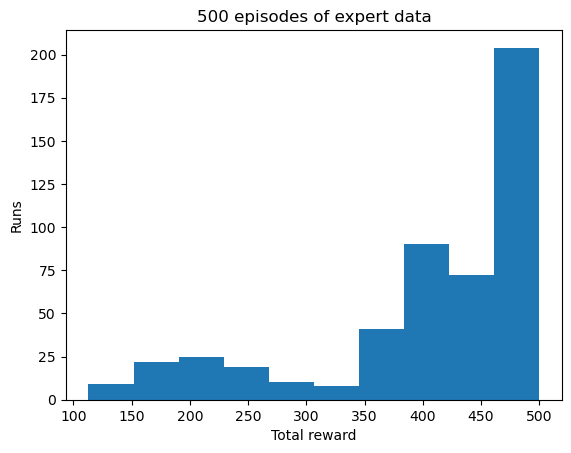

In [57]:
# taking a look at the expert data
hist = df.groupby('episode')['reward'].sum().apply(lambda a : a+250 if a <500 else a)
plt.hist(hist)
plt.title("500 episodes of expert data")
plt.xlabel("Total reward")
plt.ylabel("Runs")

In [58]:
sizes = [100, 250, 500]
splits = [(1.0,.0), (.5,.5), (.0,1.0)]

datasets = {100:{},250:{},500:{}}

for size in sizes:
    df = pd.read_csv(f'Data/Data{str(size)}.csv', sep=';', encoding='utf-8')
    df_random = pd.read_csv(f'Data_random/Data{size}.csv', sep=';', encoding='utf-8')
    for split in splits:
        
#         split_n = size*split[1]
#         x = df[df['episode'] < split_n]
#         y = df_random[df_random['episode'] > split_n]
        
        x = df.sample(int(size*split[1]))
        y = df_random.sample(int(size*split[0]))
        
        datasets[size][split] = pd.concat([x,y])


<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>


## Imitation learning 

Since we'll be using the logistic regression from Sklearn, we will be experimenting with the C parameters instead of the learning rate.

In [59]:
# creating the logistic regression model for the immitation

immitation_models = {100:{},250:{},500:{}}

for size in sizes:
    for split in splits:
        data = datasets[size][split]
        y = data['action']
        X = data[['s1','s2','s3','s4']]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
        
        lr0 = LogisticRegression(random_state=0,max_iter=100,multi_class='multinomial',C=.7).fit(X_train.values,y_train.values)
        lr1 = LogisticRegression(random_state=0,max_iter=100,multi_class='multinomial',C=1).fit(X_train.values,y_train.values)
        
        # now creating immitation model with the log regress 
        model0 = qlearning(env, alpha=learning_rate, epsilon=epsilon, bins=n_bins,lr_model=lr0)
        model1 = qlearning(env, alpha=learning_rate, epsilon=epsilon, bins=n_bins,lr_model=lr1)
        
        immitation_models[size][split] = (model0,model1)
        

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>


### Evaluating The Immitation model

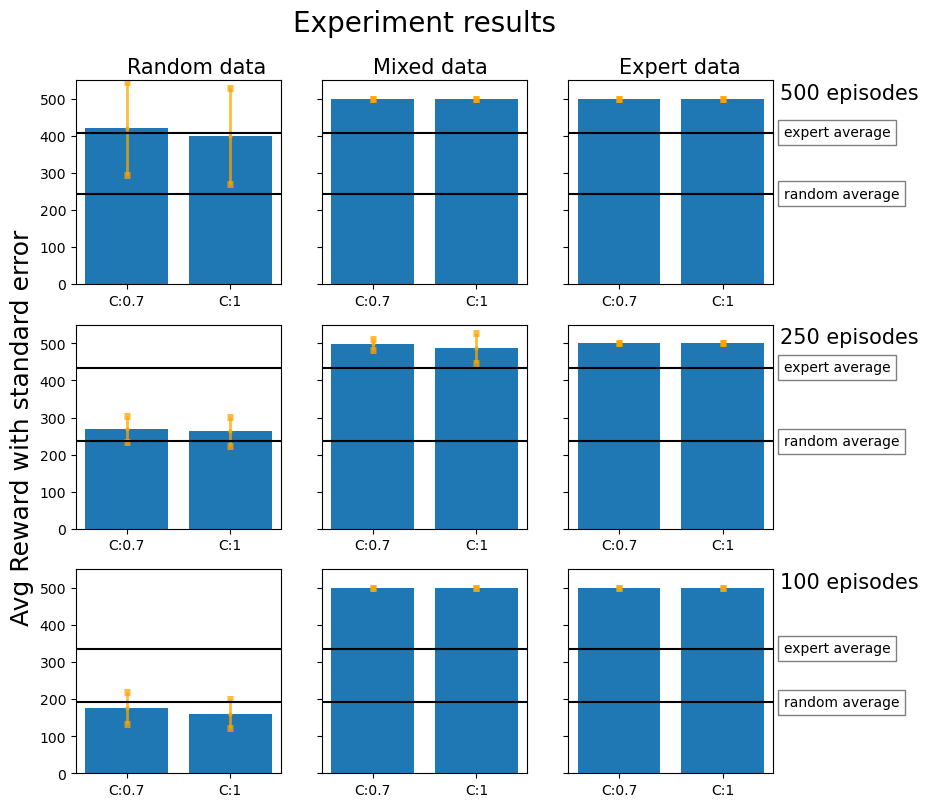

In [12]:
sizes = [500, 250, 100]
splits = [(1.0,.0), (.5,.5), (.0,1.0)]

fig, ax = plt.subplots(len(sizes),len(splits), sharey='row', figsize=(9, 9))
ax[0][1].set_title("Experiment results", y=1.2, fontsize=20)
ax[1][0].set_ylabel(f'Avg Reward with standard error', fontsize=18)

for j,split in enumerate(splits):
    for i,size in enumerate(sizes):
        
        split_text = {(1.0,.0):'Random data', (.5,.5):'Mixed data', (.0,1.0):'Expert data'}
        
        expert_policy = pd.read_csv(f'Data/Data{str(size)}.csv', sep=';', encoding='utf-8')
        random_policy = pd.read_csv(f'Data_random/Data{size}.csv', sep=';', encoding='utf-8')
        
        random_avg = np.mean(random_policy.groupby('episode').sum()['reward'].apply(lambda a: a + 250 if a != 500 else a))
        expert_avg = np.mean(expert_policy.groupby('episode').sum()['reward'].apply(lambda a: a + 250 if a != 500 else a))
        
        if i == 0:
            text = ax[i][j].text(0,570,f"{split_text[split]}", size=15)
        if j == 2:
            text = ax[i][j].text(1.55,500,f"{str(size)} episodes", size=15)
            
            ax[i][j].text(1.05, expert_avg, "expert average", va='center', ha="left", bbox=dict(facecolor="w",alpha=0.5),transform=ax[i][j].get_yaxis_transform())
            ax[i][j].text(1.05, random_avg, "random average", va='center', ha="left", bbox=dict(facecolor="w",alpha=0.5),transform=ax[i][j].get_yaxis_transform())

        
        X = []
        Y = []
        err = []
        for z,model in enumerate(immitation_models[size][split]):
            C = model.lr_model.get_params()['C']
            
            test_result = model.gen_data(episodes=100,imitation=True, reward_=True)[0]
            
            # compensating penalty for the purpose of visualization (normally all non-sucessfull would have an penalty)
            test_result = [x if x==500 else x+250 for x in test_result]
            
            test_avg = np.mean(test_result)
            test_std = np.std(test_result)
            # plot here the result
            
            X.append('C:' +str(C))
            Y.append(test_avg)
            err.append(test_std)
            
        ax[i][j].set_ylim([0, 550])
        ax[i][j].bar(X,Y, alpha=1)
        ax[i][j].errorbar(X, Y, err, fmt='.', color='orange', elinewidth=2,capthick=5,errorevery=1, alpha=0.75, ms=4, capsize = 2)
        ax[i][j].axhline(random_avg, color="black")
        ax[i][j].axhline(expert_avg, color="black") 
#         ax[i][j].grid(visible=True)

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>


## Training and evaluating fitted Q-learning 

In [60]:
# hyper-params

learning_rates = [.75, .99]
epsilon = 0


split (1.0, 0.0) size 500
split (1.0, 0.0) size 250
split (1.0, 0.0) size 100
split (0.5, 0.5) size 500
split (0.5, 0.5) size 250
split (0.5, 0.5) size 100
split (0.0, 1.0) size 500
split (0.0, 1.0) size 250
split (0.0, 1.0) size 100


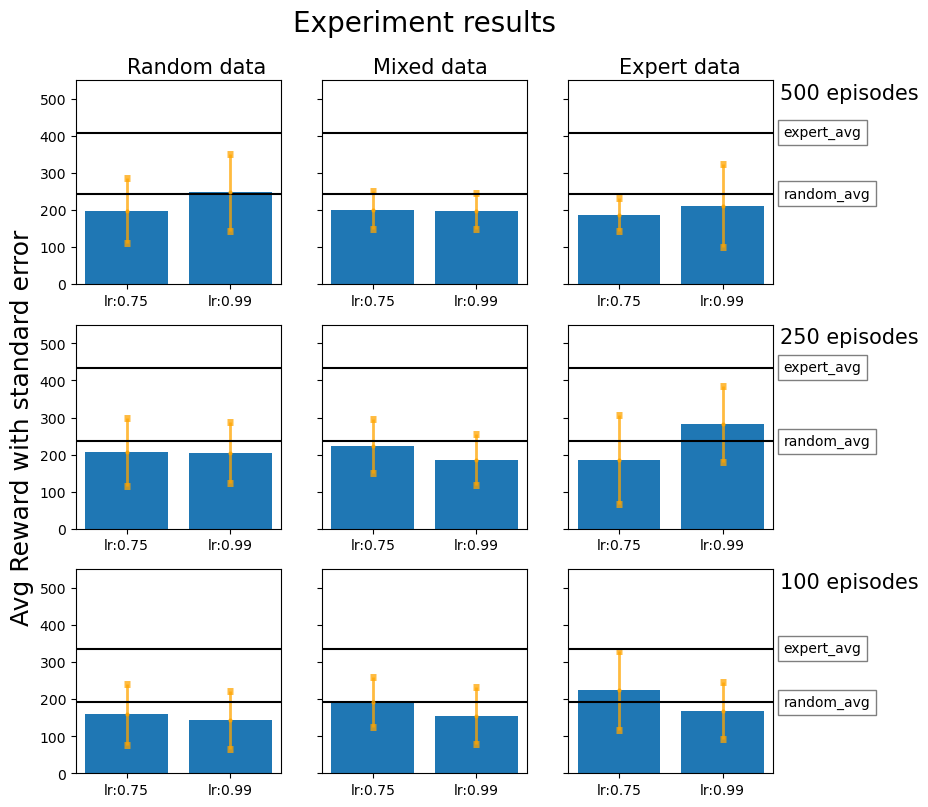

In [63]:
# fitted model
sizes = [500, 250, 100]
splits = [(1.0,.0), (.5,.5), (.0,1.0)]

fig, ax = plt.subplots(len(sizes),len(splits), sharey='row', figsize=(9, 9))
ax[0][1].set_title("Experiment results", y=1.2, fontsize=20)
ax[1][0].set_ylabel(f'Avg Reward with standard error', fontsize=18)

for j,split in enumerate(splits):
    for i,size in enumerate(sizes):
        data = datasets[size][split]
        
        print(f"split {str(split)} size {str(size)}")
        
        split_text = {(1.0,.0):'Random data', (.5,.5):'Mixed data', (.0,1.0):'Expert data'}
        
        expert_policy = pd.read_csv(f'Data/Data{str(size)}.csv', sep=';', encoding='utf-8')
        random_policy = pd.read_csv(f'Data_random/Data{size}.csv', sep=';', encoding='utf-8')
        
        random_avg = np.mean(random_policy.groupby('episode').sum()['reward'].apply(lambda a: a + 250 if a != 500 else a))
        expert_avg = np.mean(expert_policy.groupby('episode').sum()['reward'].apply(lambda a: a + 250 if a != 500 else a))
        
        if i == 0:
            text = ax[i][j].text(0,570,f"{split_text[split]}", size=15)
        if j == 2:
            text = ax[i][j].text(1.55,500,f"{str(size)} episodes", size=15)
            
            ax[i][j].text(1.05, expert_avg, "expert_avg", va='center', ha="left", bbox=dict(facecolor="w",alpha=0.5),transform=ax[i][j].get_yaxis_transform())
            ax[i][j].text(1.05, random_avg, "random_avg", va='center', ha="left", bbox=dict(facecolor="w",alpha=0.5),transform=ax[i][j].get_yaxis_transform())

        
        X = []
        Y = []
        err = []
        for lr in learning_rates:
            
            model = qlearning(env, gamma=lr, epsilon=1, bins=10)
            model.offline_train(data, k=5)
            
            test_result = model.gen_data(episodes=100,imitation=False, reward_=True)[0]
            
            # compensating penalty for the purpose of visualization (normally all non-sucessfull would have an penalty)
            test_result = [x if x==500 else x+250 for x in test_result]
            
            test_avg = np.mean(test_result)
            test_std = np.std(test_result)
            # plot here the result
            
            X.append('lr:' + str(lr))
            Y.append(test_avg)
            err.append(test_std)
        

        ax[i][j].set_ylim([0, 550])
        ax[i][j].bar(X,Y, alpha=1)
        ax[i][j].errorbar(X, Y, err, fmt='.', color='orange', elinewidth=2,capthick=5,errorevery=1, alpha=0.75, ms=4, capsize = 2)
        ax[i][j].axhline(random_avg, color="black")
        ax[i][j].axhline(expert_avg, color="black") 




<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>


### Single evaluation of the  Fitted Q-learning model

Text(0, 0.5, 'Bumber or runs')

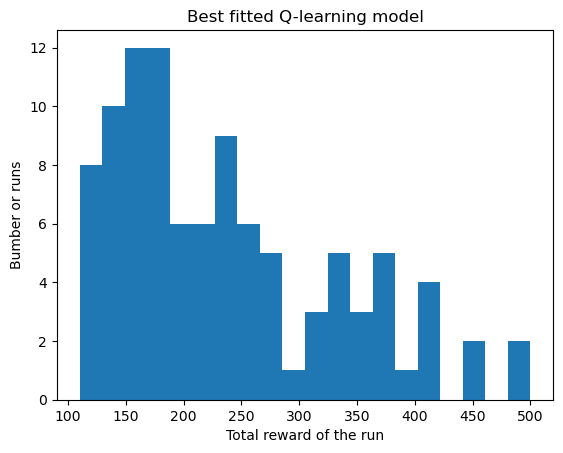

In [65]:
data = datasets[250][(.0,1.0)]

model = qlearning(env, gamma=.99, epsilon=1, bins=10)
model.offline_train(data, k=5)

test_result = model.gen_data(episodes=100,imitation=False, reward_=True)[0]
# compensating penalty for the purpose of visualization (normally all non-sucessfull would have an penalty)
test_result = [x if x==500 else x+250 for x in test_result]
    
test_result = model.gen_data(episodes=100, reward_=True)[0]
test_result = [x if x==500 else x+250 for x in test_result]
plt.hist(test_result,bins=20)
plt.title("Best fitted Q-learning model")
plt.xlabel("Total reward of the run")
plt.ylabel("Bumber or runs")

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

# MLP implementation


In [24]:
from sklearn.neural_network import MLPRegressor

# no discretizer would be needed for the mlp model as we can utilize the real contious value of each state
# and the main idea is that the neural net will be able to basically do both jobs, considering values near
# to each other as "similar" and giving similar results. This would basically simulate the discretization

class mlp_fitted:
    def __init__(self, gamma=0.99, hidden_layer_sizes=(4, 20), lr=0.001, max_iter=500):
        self.g = gamma
        self.model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, learning_rate_init=lr, max_iter=max_iter,
                                  random_state=0)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def update(self, data):
        state = data[['s1', 's2', 's3', 's4']].copy()
        state_0 = data[['s1', 's2', 's3', 's4']].copy()
        state_1 = data[['s1', 's2', 's3', 's4']].copy()

        state_0['action'] = 0
        state_1['action'] = 1

        next_state_0 = data[['ns1', 'ns2', 'ns3', 'ns4']].copy()
        next_state_1 = data[['ns1', 'ns2', 'ns3', 'ns4']].copy()

        next_state_0['action'] = 0
        next_state_1['action'] = 1

        action = data['action']
        r = data['reward']

        self.fit(state_0.head(1).values, [0])

        q_0 = self.predict(state_0.values)
        q_1 = self.predict(state_1.values)
        q = np.array([q_0, q_1])

        next_q_0 = self.predict(next_state_0.values)
        next_q_1 = self.predict(next_state_1.values)

        next_q = np.array([next_q_0, next_q_1])
        max_next_q = np.max(next_q, axis=0)
        Y = q.copy().T

        for i in range(len(state)):
            Y[i, int(action[i])] = r[i] + self.g * max_next_q[i]

        state['action'] = 0
        self.fit(state, Y[:, 0])

        state['action'] = 1
        self.fit(state, Y[:, 1])


def test_mlp(env, model, episodes=100,verbose=True):
    rewards = []
    for i in range(episodes):
        state = env.reset()[0]
        done = False
        total_reward = 0
        while not done:
            state_0 = np.array(list(state) + [0]).reshape(1, -1)
            state_1 = np.array(list(state) + [1]).reshape(1, -1)

            pred_0 = model.predict(state_0)
            pred_1 = model.predict(state_1)
            if pred_0 > pred_1:
                action = 0
            else:
                action = 1

            new_state, reward, done, time_limit, prob = env.step(action)
            total_reward += reward
            state = new_state

            if time_limit:
                break
        if verbose:
            print("Episode:", i + 1, "Total reward:", total_reward)
        rewards.append(total_reward)
    return rewards


In [25]:
model = mlp_fitted()

data = pd.read_csv(f'Data/Data500.csv', sep=';', encoding='utf-8')

In [ ]:
model.update(data)
rewards = test_mlp(env, model,verbose=False)

Text(0, 0.5, 'Number of runs')

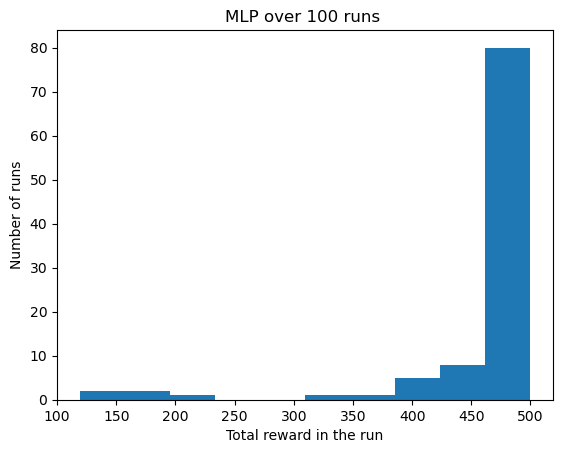

In [66]:
plt.hist(rewards)
plt.title("MLP over 100 runs ")
plt.xlabel("Total reward in the run")
plt.ylabel("Number of runs")

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

# Discussion


The environment used in this experiment was the same as the previous assignment. An environment with a cart with a pole trying to keep a pole straight up for as long as possible( the longer the more reward). It has 4 features that represented the state in a continuous value that were later translated into 10 bins for discretization and easier modelling. 

Two algorithms were compared, imitation learning and the Fitted Q-learning algorithm.

The comparison was made with different plots since the tunning of the models involved different hyperparameters. However, all plots were available, alongside a histogram of rewards obtained for the fitted q-learning and then the same histogram for the extra MLP model.

It's good to point out that the expert model was a classical q-learning, equal to the one used in assignment 2, my expert model had a q-table of 10000 * 2 states, for every configuration of possible states and action, usually, this will not be a good thing, but since here it was being used as an expert system, and it had access to plenty of data/training, it became a good choice since it provided very good data.

Also, given the complexity and time to train the models, the hyperparameter tuning was done by hand, with more aggressive choices chosen initially until a good result was found, and then the second one was chosen to provide perspective.

Unfortunately, I was not able to properly implement the fitted q-learning in a way that achieved performance levels as shown in the literature. With correct implementation, the fitted q-learning should give results considerably better than a simple imitation model, however, in my experiments, only a few runs managed to get good results(above 200). Meanwhile, some configurations for imitation learning managed to get almost perfect runs.

We can also see that the usage of more expert data helped drastically the model, that can be because for a simple imitation model, it's best to only show it the best possible data, and at the same time, the expert model managed to get more data since every episode lasted way more steps than a random one. It is also remarkable that the imitation model managed to get values even above our expert model, probably due to the exploration of the expert.

However, in the graphs, it's possible to see that there were cases with high variation in the results, probably due to the fact that whenever the imitation diverged from the data it had seen, it started accumulating errors and quickly dropped the pole.

The bonus exercise was done with one single MLP, it was configured in a way that one of the features represented the action taken, this made it harder to work with since you have to manipulate the input data to include which action you want to predict, however, it showed good results regardless. It's possible to see in the final histogram that the MLP model managed to get the best results among all the other models, with near-perfect runs.
